<a href="https://colab.research.google.com/github/VMBoehm/RNF/blob/colab/notebooks/FIDScore_and_Reconstruction_Error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### In this notebooks we measure the pixel-wise reconstruction error of a model and the FID scores of sampels and reconstructions

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
 
plt.rcParams.update({'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [2]:
import pae.load_data as ld
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist)

In [3]:
from pae.fid_score import *

#### choose model by specifying the filename
for VAE use *params_fmnist_-1_32_infoGAN_VAE_comp_AE_full_sigma*

In [43]:
PROJECT_PATH = "../../" 
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')
param_file = 'params_fmnist_-1_32_infoGAN_AE_full_sigma'
params      = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [44]:
load_func                                          = load_funcs[params['data_set']]
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_dir'],flatten=False,params=params)

if np.all(x_test)==None:
    x_test=x_valid

x_train    = x_train/255.-0.5
x_test     = x_test/255.-0.5
x_valid    = x_valid/255.-0.5


In [45]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_dir          = os.path.join(params['module_dir'],'nvp')

In [46]:
tf.reset_default_graph()

data          = tf.placeholder(shape=[None]+params['data_shape'],dtype=tf.float32)
latent_point  = tf.placeholder(shape=[None,params['latent_size']],dtype=tf.float32)
sample_size   = tf.placeholder_with_default(params['batch_size'], shape=[])
encoder       = hub.Module(encoder_path, trainable=False)
decoder       = hub.Module(generator_path, trainable=False)
nvp           = hub.Module(nvp_dir, trainable=False)

prior         = tfd.MultivariateNormalDiag(tf.zeros(params['latent_size']), scale_identity_multiplier=1.0)

encoded, _    = tf.split(encoder({'x':data},as_dict=True)['z'], 2, axis=-1)
decoded       = decoder({'z':encoded},as_dict=True)['x']

decoded_latent= decoder({'z':latent_point},as_dict=True)['x']

sigma         = tf.reduce_mean(tf.sqrt(tf.square(data-decoded)),axis=0)

samples         = prior.sample(sample_size)
decoded_samples = decoder({'z':samples},as_dict=True)['x']
nvp_samples         = nvp({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':samples}, as_dict=True)['fwd_pass']
decoded_nvp_samples = decoder({'z':nvp_samples},as_dict=True)['x']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [47]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#### measure the pixel-wise reconstruction noise and store it in the parameter file

In [48]:
rec, d            = sess.run([decoded,data], feed_dict={data:x_valid[0:params['batch_size']]})
recs=[]
delta = len(x_valid)%params['batch_size']
for ii in range(10000//128):
    recs+=[sess.run(decoded, feed_dict={data:x_valid[ii*params['batch_size']:(ii+1)*params['batch_size']]})]
data_sample=np.concatenate((x_valid[(ii+1)*params['batch_size']:len(x_valid)],x_valid[0:params['batch_size']-delta]))
recs+=[sess.run(decoded, feed_dict={data:data_sample})]
recs = np.asarray(recs).reshape([-1,28,28])[0:len(x_valid)]



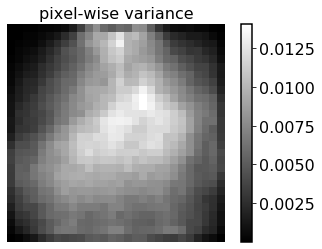

mean variance 0.006416988513379252
minimum variance 9.336173410118349e-08
maximal variance 0.014054405703379798


In [49]:
full_sigma = np.sqrt(np.mean(np.square(x_valid.reshape([-1,28,28])-recs.reshape(-1,28,28)),axis=0))
mean_sigma = np.mean(full_sigma)
mean_var   = np.mean(full_sigma**2)
plt.figure()
plt.title('pixel-wise variance')
plt.imshow((full_sigma**2).reshape(28,28), cmap='gray')
plt.colorbar()
plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'measured_sigma.pdf'),bbox_inches='tight')
plt.show()
params['full_sigma']=full_sigma
pickle.dump(params,open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'wb'))
print('mean variance', mean_var)
print('minimum variance', np.min(full_sigma**2))
print('maximal variance', np.max(full_sigma**2))

#### make the plots of reconstructions and samples that go into the paper

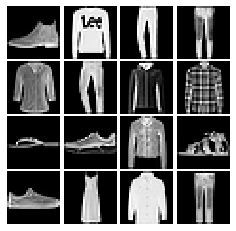

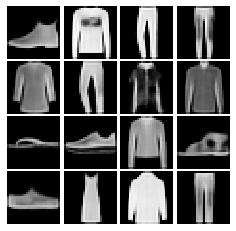

In [50]:
random_nvp_samples = sess.run(decoded_nvp_samples)
jj=1
plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow((d[ii]+0.5).reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'orig_valid_set.pdf'),bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow((rec[ii]+0.5).reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')

plt.savefig(os.path.join(params['plot_dir'],'rec_valid_set.pdf'),bbox_inches='tight')
plt.show()

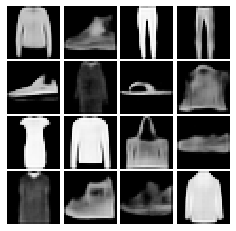

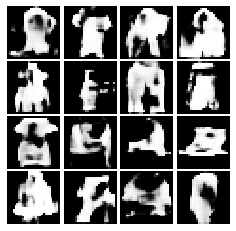

In [51]:
random_nvp_samples=[]
for ii in range(10000//128+1):
    random_nvp_samples+=[sess.run(decoded_nvp_samples)]
random_nvp_samples=np.asarray(random_nvp_samples).reshape((-1,28,28))[0:10000]
plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow((random_nvp_samples[ii]+0.5).reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'nvp_samples.pdf'),bbox_inches='tight')
plt.show()

random_samples=[]
for ii in range(10000//128+1):
    random_samples+=[sess.run(decoded_samples)]
random_samples=np.asarray(random_samples).reshape((-1,28,28))[0:10000]

plt.figure(figsize=(4,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow((random_samples[ii]+0.5).reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
plt.savefig(os.path.join(params['plot_dir'],'raw_samples.pdf'),bbox_inches='tight')
plt.show()

#### measure the FID scores. For the FID score measurement we use code from https://github.com/daib13/TwoStageVAE/blob/master/fid_score.py

In [52]:
def evaluate_fid_score(fake_images, real_images,norm=True):
    np.random.shuffle(real_images)
    assert(len(real_images)>=10000)
    assert(len(real_images)>=10000)
    real_images = real_images[0:10000]
    fake_images = fake_images[0:10000]
    real_images = preprocess_fake_images(real_images, norm)
    fake_images = preprocess_fake_images(fake_images, norm)
    print(real_images.shape)
    inception_path = check_or_download_inception()

    create_inception_graph(inception_path)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    print('calculating tf features...')
    real_out = get_activations_tf(real_images, sess)
    fake_out = get_activations_tf(fake_images, sess)
    fid_result = fid_score(real_out, fake_out)

    return fid_result

In [53]:
evaluate_fid_score(np.expand_dims(np.reshape(x_valid,(-1,28,28)),-1), np.expand_dims(np.reshape(random_samples,(-1,28,28)),-1))

norm =  True
norm =  True
(10000, 28, 28, 3)


/global/homes/v/vboehm/.conda/envs/tflowRNF/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


calculating tf features...


103.08043917398682

In [40]:
evaluate_fid_score(np.expand_dims(np.reshape(x_valid,(-1,28,28)),-1), np.expand_dims(np.reshape(random_nvp_samples,(-1,28,28)),-1))

norm =  True
norm =  True
(10000, 28, 28, 3)


/global/homes/v/vboehm/.conda/envs/tflowRNF/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


calculating tf features...


34.965404581144206

In [41]:
evaluate_fid_score(np.expand_dims(np.reshape(x_valid,(-1,28,28)),-1), np.expand_dims(np.reshape(recs,(-1,28,28)),-1))

norm =  True
norm =  True
(10000, 28, 28, 3)
calculating tf features...


31.452829117423025

In [42]:
evaluate_fid_score(np.expand_dims(np.reshape(x_valid,(-1,28,28)),-1), np.expand_dims(np.reshape(x_train,(-1,28,28)),-1))

norm =  True
norm =  True
(10000, 28, 28, 3)
calculating tf features...


2.55518915384563